# Hourly Time Series Forecasting using XGBoost
#### Tutorial en: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
#### Documentación de Scikit-Learn API: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

In [2]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached xgboost-1.0.2.tar.gz (821 kB)
  Created wheel for xgboost: filename=xgboost-1.0.2-cp37-cp37m-macosx_10_7_x86_64.whl size=3381057 sha256=1970d5feeb0e54ea6572f507dc9a5aa7967431edbebf54bf98c81cbf3b9ba51e
  Stored in directory: /Users/anamendoza/Library/Caches/pip/wheels/c9/1c/c9/db0188e82127a4f3c66d031147312a03e8a0676d907ecd7fbb
Successfully built xgboost


In [3]:
import numpy as np      # algebra lineal
import pandas as pd     # data processing
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [6]:
pjme = pd.read_csv('/Users/anamendoza/Desktop/Cemex Ventures/Energy Project/Time series - Energy Prediction Tutorial/energy consumption dataset/PJME_hourly.csv',index_col = [0], parse_dates = [0])

In [21]:
pjme.tail() # visualizacion de datos

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


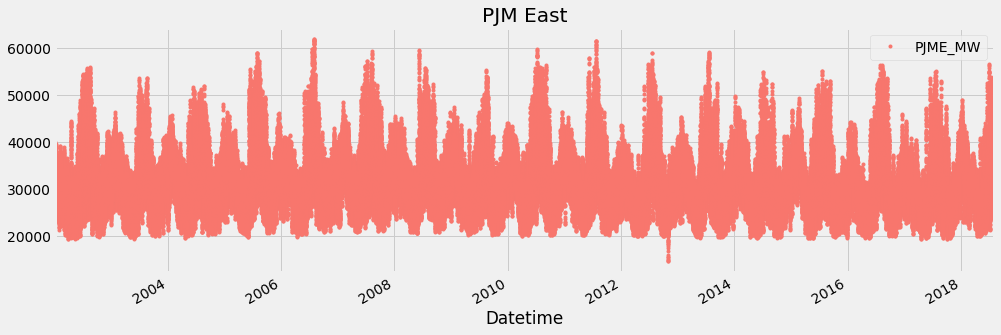

In [8]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

# Split del Train y del Test
#### 2002-2015 Train y 2015-2018 Test

In [9]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy() # pone datos 2002-2015
pjme_test = pjme.loc[pjme.index > split_date].copy()  # pone datos 2015-2018

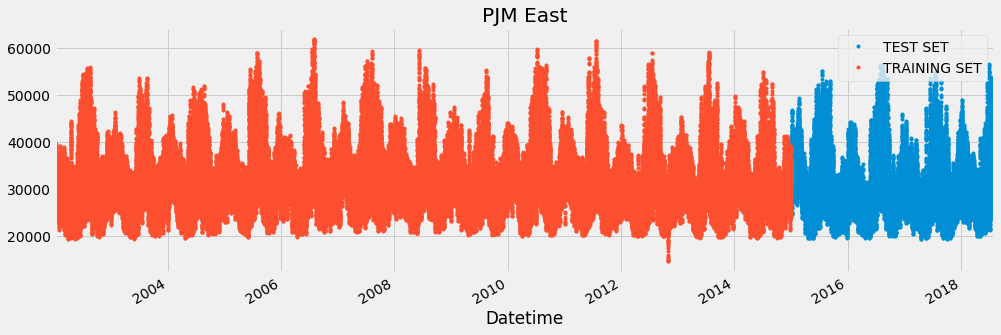

In [18]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.') # hace el plot de los 2 juntos

# Crea los Features
#### Date, hour, dayofweek, etc

In [20]:
def create_features(df, label=None): # es una funcion
    """
    Creates time series features from datetime index 
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label: # si es por hora
        y = df[label] # aplica df['date'].dt.hour
        return X, y
    return X

In [41]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

# Modelo XGBoost

In [60]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# Feature Importances
#### En cual feature el modelo esta basandose mas para la prediccion

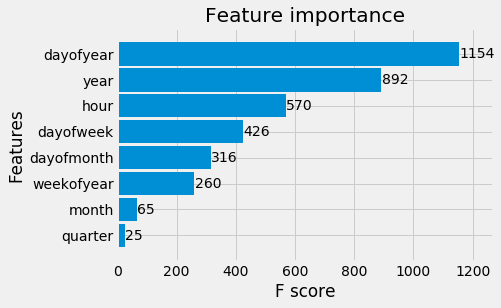

In [59]:
_ = plot_importance(reg, height=0.9)

# Predicción en el set de Test

In [61]:
pjme_test['MW_Prediction'] = reg.predict(X_test) # agrega la columna de prediccion a la tabla de test
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

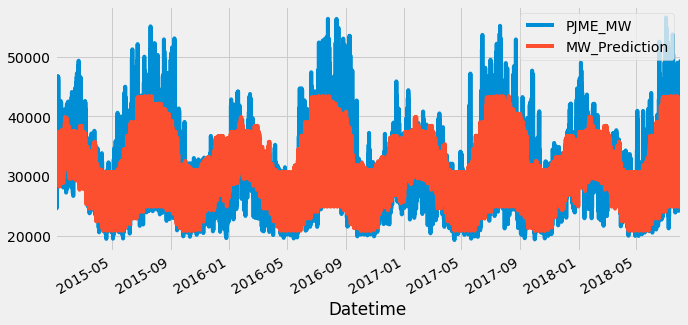

In [80]:
_ = pjme_test[['PJME_MW','MW_Prediction']].plot(figsize=(10, 5))

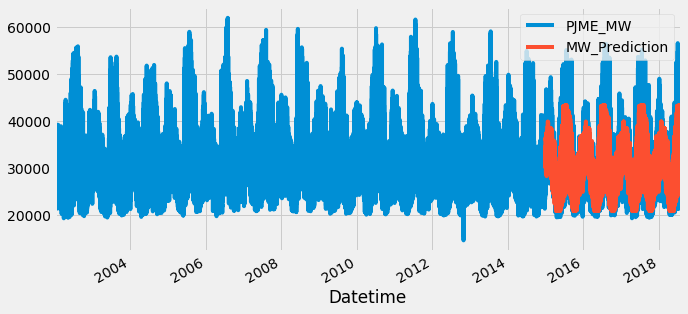

In [81]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(10, 5))

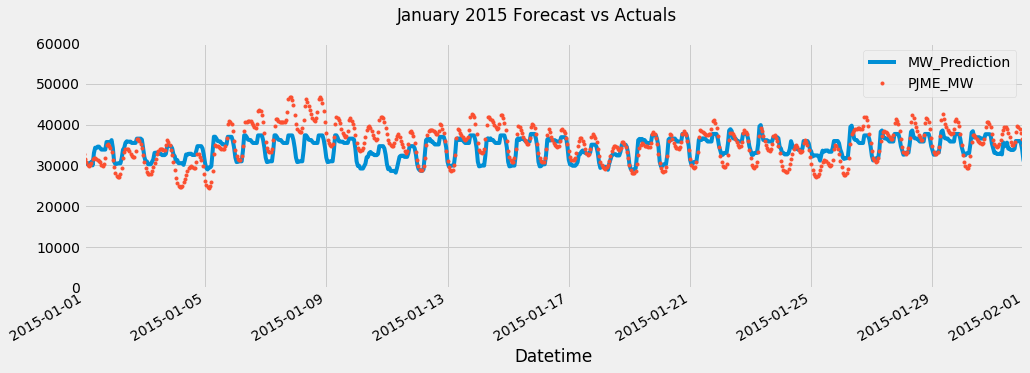

In [82]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

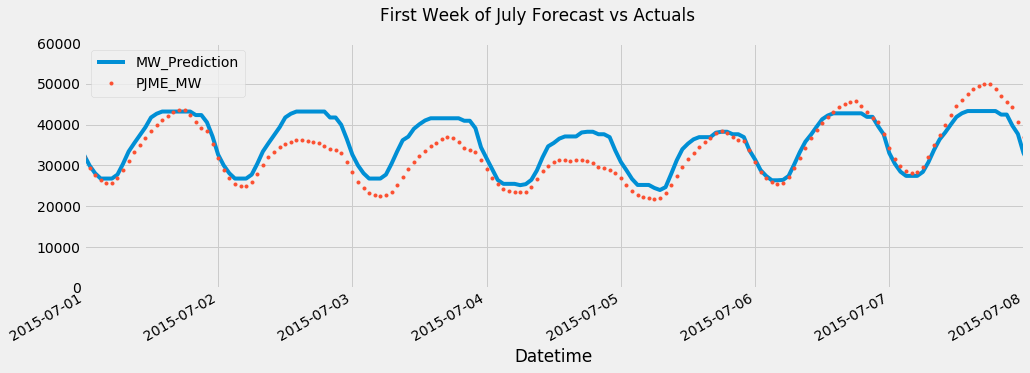

In [83]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

# Error Metrics On Test Set
#### MAE   =  Mean absolute error    
#### MAPE =  Mean absolute percentage error

In [84]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2757.2169004982866

In [85]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [86]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.510847348494002

# Peores días (error más grande)

In [87]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [88]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36429.839844 -8029.882894  8029.882894
2017 2     24          26445.083333   34425.839844 -7980.756429  7980.756429
           25          24344.458333   31702.664062 -7358.206299  7358.206299
     9     4           26552.416667   33609.351562 -7056.935954  7056.935954
     2     20          27070.583333   33860.238281 -6789.655355  6789.655355
     9     1           27280.500000   33966.476562 -6685.977132  6685.977132
     2     19          24555.500000   31178.527344 -6623.027913  6623.027913
2018 2     21          27572.500000   34057.515625 -6485.015869  6485.015869
2017 3     1           27574.125000   34057.515625 -6483.390869  6483.390869
     2     23          27663.416667   34141.667969 -6478.251872  6478.251872